In [2]:
! python3 -m pip install --upgrade pip
! python3 -m pip install  --upgrade SpeechRecognition
! python3 -m pip install  --upgrade pydub
! python3 -m pip install  --upgrade sklearn
! python3 -m pip install --upgrade textstat

     |████████████████████████████████| 1.5 MB 8.4 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 32.8 MB 218 kB/s eta 0:00:011   |██▊                             | 2.8 MB 7.6 MB/s eta 0:00:04     |████▏                           | 4.2 MB 7.6 MB/s eta 0:00:04     |███████▉                        | 8.0 MB 7.6 MB/s eta 0:00:04     |████████▍                       | 8.6 MB 7.6 MB/s eta 0:00:04     |██████████▊                     | 11.0 MB 7.6 MB/s eta 0:00:03�█████████████████████▏       | 24.9 MB 3.3 MB/s eta 0:00:03
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=cd5310f807987fc06f02abb201dd0cff4d0b74341b74fb86f1f58e60b780a177
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
     |████████████████████████████████

In [3]:
import IPython.display as ipd
import joblib
import kapre
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
import textstat
import time
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from pydub.silence import split_on_silence 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Transcribe audio data to txt data

In [5]:
# TODO make an input from user
data_path = '/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train'

audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

lang_ = 'en-US'

In [6]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

meta['ID'] = meta['ID'].str.strip()

meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,NA,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,29,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [7]:
sum(meta.MMSE == ' NA')

1

In [8]:
# Replace all NAs
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

# TODO - see if this works - Replace all scores in cc group to 30
# meta.loc[meta['Group'] == 'cc', 'MMSE'] = 30
# meta

In [9]:
meta.dtypes

index      int64
ID        object
Age        int64
Gender    object
MMSE       int64
Group     object
dtype: object

In [10]:
# https://www.geeksforgeeks.org/python-speech-recognition-on-large-audio-files/

# a function that splits the audio file into chunks 
# and applies speech recognition 
def silence_based_conversion(path, wav_file): 
    text_df = pd.DataFrame()
  
    # open the audio file stored in 
    # the local system as a wav file. 
    song = AudioSegment.from_wav(path + wav_file) 
    print(song)
  
    # open a file where we will concatenate   
    # and store the recognized text 
    text_file = wav_file.partition('.')[0] + ".txt"
    text_file_dir = path + "output_text/" 
    if not os.path.exists(text_file_dir):
        os.makedirs(text_file_dir)    
    text_file_path = text_file_dir + text_file
    fh = open(text_file_path, "w+") 
          

    dBFS = song.dBFS
    print('dBFS: ' + str(dBFS))
    # chunks = split_on_silence(song, 
    #     min_silence_len = 500,
    #     silence_thresh = dBFS-16,
    #     keep_silence = 250 
    # )

    # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(song, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 250, 
  
        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = dBFS - 16
        # keep_silence = 250
    ) 
    # setting minimum length of each chunk to 25 seconds
    target_length = 20 * 1000 
    output_chunks = [chunks[0]]
    for chunk in chunks[1:]:
      print('Length of chunk: ' + str(len(output_chunks[-1])) )
      if len(output_chunks[-1]) < target_length:
        output_chunks[-1] += chunk
      else:
        # if the last output chunk is longer than the target length,
        # we can start a new one
        output_chunks.append(chunk)    
    # print(chunks)
  
    # create a directory to store the audio chunks. 
    try: 
        os.mkdir(path + 'audio_chunks') 
    except(FileExistsError): 
        pass
  
    # move into the directory to 
    # store the audio files. 
    os.chdir(path +'audio_chunks') 
  
    i = 0
    # process each chunk 
    for chunk in output_chunks: 
              
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 10) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        text_file_id = text_file.partition('.')[0]
        chunk_file_name = text_file_id + "_" + "chunk" + str(i) + ".wav"
        print("saving " + chunk_file_name) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("./" + chunk_file_name, bitrate ='192k', format ="wav") 
  
        # the name of the newly created chunk 
        filename = chunk_file_name
  
        print("Processing chunk file: " + filename) 
  
        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 
  
        # create a speech recognition object 
        r = sr.Recognizer() 
  
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            #r.adjust_for_ambient_noise(source) 
            audio_listened = r.record(source) 
  
        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file. 
            fh.write(rec+". ") 
            text_df = text_df.append({'ID': text_file_id, 'Text': rec}, ignore_index = True)
  
        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 
  
        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 
  
        i += 1
    return text_df

# silence_based_conversion(audio_path_cc, 'S001.wav')        
# text_df = silence_based_conversion(audio_path_cd, 'S079.wav')        
# print(text_df)
# silence_based_conversion(audio_path_cc + 'spkr0.wav')

In [11]:
text_dict = {"ID": [], "Text": []}

In [12]:
start_cc = time.time()
# Running for CC path
onlyfiles_cc = [f for f in listdir(audio_path_cc) if isfile(join(audio_path_cc, f))]

for filename in onlyfiles_cc:
    data = silence_based_conversion(path = audio_path_cc, wav_file = filename)
    just_name = filename.split(sep='.')[:-1][0]
    text_dict["ID"].append(just_name)
    text_dict["Text"].append(data)
end_cc = time.time()

start_cd = time.time()
# Running for CD path
onlyfiles_cd = [f for f in listdir(audio_path_cd) if isfile(join(audio_path_cd, f))]

for filename in onlyfiles_cd:
    data = silence_based_conversion(path = audio_path_cd, wav_file = filename)
    just_name = filename.split(sep='.')[:-1][0]
    text_dict["ID"].append(just_name)
    text_dict["Text"].append(data)
end_cd = time.time()

dBFS: -29.536595460200303
Length of chunk: 2103
Length of chunk: 3452
Length of chunk: 3687
Length of chunk: 4649
Length of chunk: 5800
Length of chunk: 8553
Length of chunk: 9380
Length of chunk: 9976
Length of chunk: 10628
Length of chunk: 11166
Length of chunk: 13035
Length of chunk: 13844
Length of chunk: 14793
Length of chunk: 17087
Length of chunk: 20309
Length of chunk: 373
Length of chunk: 1659
Length of chunk: 2710
Length of chunk: 4690
Length of chunk: 6831
Length of chunk: 7762
Length of chunk: 10757
Length of chunk: 11865
Length of chunk: 13188
Length of chunk: 15975
Length of chunk: 17924
Length of chunk: 21843
Length of chunk: 955
Length of chunk: 4204
Length of chunk: 6487
Length of chunk: 9345
Length of chunk: 10668
Length of chunk: 12271
saving S001_chunk0.wav
Processing chunk file: S001_chunk0.wav
saving S001_chunk1.wav
Processing chunk file: S001_chunk1.wav
saving S001_chunk2.wav
Processing chunk file: S001_chunk2.wav
dBFS: -43.94773199993912
Length of chunk: 192
Len

saving S012_chunk1.wav
Processing chunk file: S012_chunk1.wav
dBFS: -41.97618855242873
Length of chunk: 469
Length of chunk: 2030
Length of chunk: 2285
Length of chunk: 3820
Length of chunk: 4224
Length of chunk: 5097
Length of chunk: 5335
Length of chunk: 5688
Length of chunk: 5889
Length of chunk: 7049
Length of chunk: 7343
Length of chunk: 8353
Length of chunk: 11489
Length of chunk: 12189
Length of chunk: 18896
saving S013_chunk0.wav
Processing chunk file: S013_chunk0.wav
dBFS: -40.09809849506211
Length of chunk: 1115
Length of chunk: 3842
Length of chunk: 4984
Length of chunk: 5633
Length of chunk: 6085
Length of chunk: 7116
Length of chunk: 9515
Length of chunk: 10449
Length of chunk: 10665
Length of chunk: 12446
Length of chunk: 13689
Length of chunk: 14969
Length of chunk: 15331
Length of chunk: 15859
Length of chunk: 17195
Length of chunk: 18510
Length of chunk: 18793
Length of chunk: 19601
Length of chunk: 19842
Length of chunk: 22607
Length of chunk: 1639
Length of chunk: 18

Length of chunk: 1769
Length of chunk: 2384
Length of chunk: 3783
Length of chunk: 4886
Length of chunk: 5885
Length of chunk: 6834
Length of chunk: 7084
Length of chunk: 7403
Length of chunk: 7915
Length of chunk: 8424
Length of chunk: 8953
Length of chunk: 9937
Length of chunk: 10514
Length of chunk: 11762
Length of chunk: 11988
Length of chunk: 12968
Length of chunk: 13683
Length of chunk: 13985
Length of chunk: 15045
Length of chunk: 15581
Length of chunk: 16114
Length of chunk: 16337
Length of chunk: 18070
Length of chunk: 18338
Length of chunk: 18763
Length of chunk: 20089
Length of chunk: 1062
Length of chunk: 1751
Length of chunk: 1981
Length of chunk: 3548
Length of chunk: 4111
Length of chunk: 4970
Length of chunk: 5489
saving S028_chunk0.wav
Processing chunk file: S028_chunk0.wav
saving S028_chunk1.wav
Processing chunk file: S028_chunk1.wav
dBFS: -43.0744419788425
Length of chunk: 8572
Length of chunk: 18320
Length of chunk: 20475
Length of chunk: 631
Length of chunk: 3387
L

dBFS: -30.995559274792225
Length of chunk: 2185
Length of chunk: 4442
Length of chunk: 10851
Length of chunk: 13546
Length of chunk: 15626
Length of chunk: 19261
Length of chunk: 20252
Length of chunk: 1474
Length of chunk: 3874
Length of chunk: 5254
Length of chunk: 7643
Length of chunk: 8832
Length of chunk: 12535
Length of chunk: 13921
Length of chunk: 14996
Length of chunk: 19556
Length of chunk: 22148
Length of chunk: 1132
Length of chunk: 2829
Length of chunk: 4079
Length of chunk: 8412
Length of chunk: 9717
saving S041_chunk0.wav
Processing chunk file: S041_chunk0.wav
saving S041_chunk1.wav
Processing chunk file: S041_chunk1.wav
saving S041_chunk2.wav
Processing chunk file: S041_chunk2.wav
dBFS: -19.746097134132228
Length of chunk: 660
Length of chunk: 1571
Length of chunk: 1933
Length of chunk: 6527
Length of chunk: 8913
Length of chunk: 9869
Length of chunk: 11714
Length of chunk: 16809
Length of chunk: 17648
Length of chunk: 23095
Length of chunk: 1286
Length of chunk: 4243
L

saving S059_chunk1.wav
Processing chunk file: S059_chunk1.wav
dBFS: -23.71697373206398
Length of chunk: 2177
Length of chunk: 3539
Length of chunk: 3997
Length of chunk: 4243
Length of chunk: 7231
Length of chunk: 9387
Length of chunk: 10648
Length of chunk: 11423
Length of chunk: 12741
Length of chunk: 13958
Length of chunk: 14953
Length of chunk: 15887
Length of chunk: 17120
Length of chunk: 20456
Length of chunk: 303
Length of chunk: 1917
Length of chunk: 3600
Length of chunk: 6176
Length of chunk: 6935
Length of chunk: 7962
Length of chunk: 8485
Length of chunk: 9801
Length of chunk: 11515
Length of chunk: 12282
Length of chunk: 13031
Length of chunk: 14334
Length of chunk: 17140
Length of chunk: 18007
Length of chunk: 18268
Length of chunk: 19284
Length of chunk: 20576
Length of chunk: 1632
Length of chunk: 4057
Length of chunk: 5428
Length of chunk: 6253
Length of chunk: 8029
saving S061_chunk0.wav
Processing chunk file: S061_chunk0.wav
saving S061_chunk1.wav
Processing chunk fil

saving S079_chunk1.wav
Processing chunk file: S079_chunk1.wav
saving S079_chunk2.wav
Processing chunk file: S079_chunk2.wav
dBFS: -38.645023219821894
Length of chunk: 4167
Length of chunk: 4383
Length of chunk: 5340
Length of chunk: 5614
Length of chunk: 6689
Length of chunk: 7602
Length of chunk: 7826
Length of chunk: 8713
Length of chunk: 9028
Length of chunk: 10653
Length of chunk: 11128
Length of chunk: 11330
Length of chunk: 12667
Length of chunk: 13687
Length of chunk: 14923
Length of chunk: 15755
Length of chunk: 16728
Length of chunk: 16948
Length of chunk: 17671
Length of chunk: 18327
saving S080_chunk0.wav
Processing chunk file: S080_chunk0.wav
dBFS: -32.590471903165735
Length of chunk: 258
Length of chunk: 5690
Length of chunk: 7913
Length of chunk: 9338
Length of chunk: 10885
Length of chunk: 11691
Length of chunk: 13764
Length of chunk: 14151
Length of chunk: 14989
Length of chunk: 18028
Length of chunk: 19596
Length of chunk: 23214
Length of chunk: 1177
Length of chunk: 2

saving S087_chunk1.wav
Processing chunk file: S087_chunk1.wav
dBFS: -35.37631472044278
Length of chunk: 861
Length of chunk: 1844
Length of chunk: 2173
Length of chunk: 2762
Length of chunk: 2977
Length of chunk: 3757
Length of chunk: 4060
Length of chunk: 4276
Length of chunk: 4887
Length of chunk: 5109
Length of chunk: 5784
Length of chunk: 7386
Length of chunk: 7798
Length of chunk: 10221
Length of chunk: 10736
Length of chunk: 12518
Length of chunk: 13149
Length of chunk: 14972
Length of chunk: 15311
Length of chunk: 15794
Length of chunk: 16015
Length of chunk: 16731
Length of chunk: 17018
Length of chunk: 17768
Length of chunk: 18448
Length of chunk: 19756
saving S089_chunk0.wav
Processing chunk file: S089_chunk0.wav
dBFS: -37.927132086659505
Length of chunk: 1494
Length of chunk: 3148
Length of chunk: 6873
Length of chunk: 9337
Length of chunk: 10446
Length of chunk: 11661
Length of chunk: 13665
Length of chunk: 15304
Length of chunk: 15802
Length of chunk: 16003
Length of chunk

saving S097_chunk1.wav
Processing chunk file: S097_chunk1.wav
saving S097_chunk2.wav
Processing chunk file: S097_chunk2.wav
dBFS: -44.11639535067637
Length of chunk: 616
Length of chunk: 2709
Length of chunk: 2934
Length of chunk: 3156
Length of chunk: 3470
Length of chunk: 3930
Length of chunk: 4526
Length of chunk: 4999
Length of chunk: 5710
Length of chunk: 6492
Length of chunk: 6991
Length of chunk: 8360
Length of chunk: 10599
Length of chunk: 11464
Length of chunk: 13803
Length of chunk: 15244
Length of chunk: 15458
Length of chunk: 18729
Length of chunk: 19737
Length of chunk: 20200
Length of chunk: 1184
Length of chunk: 1620
Length of chunk: 2474
Length of chunk: 3671
Length of chunk: 4206
Length of chunk: 4521
Length of chunk: 4979
Length of chunk: 5477
Length of chunk: 5718
Length of chunk: 5928
Length of chunk: 7781
Length of chunk: 7995
Length of chunk: 8450
Length of chunk: 9172
Length of chunk: 10353
Length of chunk: 10576
Length of chunk: 10798
Length of chunk: 11006
savi

saving S108_chunk3.wav
Processing chunk file: S108_chunk3.wav
saving S108_chunk4.wav
Processing chunk file: S108_chunk4.wav
saving S108_chunk5.wav
Processing chunk file: S108_chunk5.wav
saving S108_chunk6.wav
Processing chunk file: S108_chunk6.wav
dBFS: -31.185630089687088
Length of chunk: 2255
Length of chunk: 2493
Length of chunk: 6175
Length of chunk: 6618
Length of chunk: 9660
Length of chunk: 13795
Length of chunk: 14930
Length of chunk: 17228
Length of chunk: 19156
Length of chunk: 21552
Length of chunk: 1517
Length of chunk: 3299
Length of chunk: 3918
Length of chunk: 4201
Length of chunk: 4421
Length of chunk: 6242
Length of chunk: 7086
Length of chunk: 7609
Length of chunk: 8386
Length of chunk: 10755
saving S110_chunk0.wav
Processing chunk file: S110_chunk0.wav
saving S110_chunk1.wav
Processing chunk file: S110_chunk1.wav
dBFS: -23.64005320925935
Length of chunk: 1956
Length of chunk: 6673
Length of chunk: 7613
Length of chunk: 7961
Length of chunk: 8409
Length of chunk: 8988

saving S126_chunk1.wav
Processing chunk file: S126_chunk1.wav
saving S126_chunk2.wav
Processing chunk file: S126_chunk2.wav
dBFS: -51.03324215228325
Length of chunk: 1049
Length of chunk: 2116
Length of chunk: 2453
Length of chunk: 2910
Length of chunk: 3425
Length of chunk: 3632
Length of chunk: 5074
Length of chunk: 7419
Length of chunk: 7871
Length of chunk: 9205
Length of chunk: 10402
Length of chunk: 10865
Length of chunk: 11749
Length of chunk: 12274
Length of chunk: 12589
Length of chunk: 13041
Length of chunk: 13967
Length of chunk: 14446
Length of chunk: 15461
Length of chunk: 15813
saving S127_chunk0.wav
Processing chunk file: S127_chunk0.wav
dBFS: -24.472744949851975
Length of chunk: 721
Length of chunk: 1890
Length of chunk: 2095
Length of chunk: 4124
Length of chunk: 4375
Length of chunk: 6000
Length of chunk: 6514
Length of chunk: 7134
Length of chunk: 8327
Length of chunk: 9524
Length of chunk: 12101
Length of chunk: 12663
Length of chunk: 14328
Length of chunk: 16620
Le

saving S140_chunk1.wav
Processing chunk file: S140_chunk1.wav
Could not understand audio
saving S140_chunk2.wav
Processing chunk file: S140_chunk2.wav
dBFS: -35.07044193078378
Length of chunk: 7812
Length of chunk: 8385
Length of chunk: 10150
Length of chunk: 12323
Length of chunk: 13660
Length of chunk: 15334
Length of chunk: 18014
Length of chunk: 18478
Length of chunk: 18743
Length of chunk: 19740
Length of chunk: 21060
Length of chunk: 782
Length of chunk: 1124
Length of chunk: 3492
Length of chunk: 3821
Length of chunk: 4359
Length of chunk: 5063
Length of chunk: 6239
Length of chunk: 8692
Length of chunk: 9112
Length of chunk: 10011
Length of chunk: 11544
Length of chunk: 12167
Length of chunk: 14246
Length of chunk: 14552
Length of chunk: 14861
Length of chunk: 15434
Length of chunk: 16052
saving S141_chunk0.wav
Processing chunk file: S141_chunk0.wav
saving S141_chunk1.wav
Processing chunk file: S141_chunk1.wav
dBFS: -24.733926680137778
Length of chunk: 2509
Length of chunk: 294

In [13]:
time_cc = end_cc-start_cc
print("CC transcription time: " + str(time_cc) + " seconds.")

CC transcription time: 767.7023088932037 seconds.


In [14]:
time_cd = end_cd-start_cd
print("CD transcription time: " + str(time_cd) + " seconds.")

CD transcription time: 730.7533628940582 seconds.


In [29]:
# Convert the dictionary into DataFrame 
text_df = pd.DataFrame(text_dict)
text_df

,ID,Text
0,S001,ID ...
1,S002,Empty DataFrame Columns: [] Index: []
2,S003,ID ...
3,S004,ID ...
4,S005,Empty DataFrame Columns: [] Index: []
...,...,...
103,S150,ID ...
104,S151,ID ...
105,S153,ID ...
106,S154,ID ...


In [33]:
text_df_2["Text"][0]
". ".join(text_df["Text"][0]["Text"])

"tell me everything that you see going on in that fix everything that you see happening or washing the dishes in the sink is over spilling and windows open and outside the window there's a walk or Kirk walk with a garden and you can stay another building their looks like a garage or something with curtain. grass in the garden and their dishes are two cups and saucer on the sink and this is getting your feet wet from the Overflow of the water from the sink and she seems to be oblivious to the fact that the sink is overflowing she's all so oblivious to the fact that our kids are stealing cookies out of cookie jar and the kids on the stool is going to fall off the stool. standing up there in a covered taking cookies out of the jar and then to a girl about the same age the kids are somewhere around seven or eight years old or 9 and the mother is going to get shocked when he tumbled from the cookie jar comes down and I think that's about all"

In [34]:
text_df_2["Text"][0]

"tell me everything that you see going on in that fix everything that you see happening or washing the dishes in the sink is over spilling and windows open and outside the window there's a walk or Kirk walk with a garden and you can stay another building their looks like a garage or something with curtain. grass in the garden and their dishes are two cups and saucer on the sink and this is getting your feet wet from the Overflow of the water from the sink and she seems to be oblivious to the fact that the sink is overflowing she's all so oblivious to the fact that our kids are stealing cookies out of cookie jar and the kids on the stool is going to fall off the stool. standing up there in a covered taking cookies out of the jar and then to a girl about the same age the kids are somewhere around seven or eight years old or 9 and the mother is going to get shocked when he tumbled from the cookie jar comes down and I think that's about all"

In [38]:
text_df_2 = text_df.copy(deep=True)
i = 0
for row in text_df["ID"]:
    print("on file: " + str(text_df["ID"][i]))
    try:
        text_df_2["Text"][i] = ". ".join(text_df["Text"][i]["Text"])
        i = i + 1
    # catch when there is no text to join 
    except KeyError:
        print("No text for file: " + str(text_df_2["ID"][i]))
        text_df_2["Text"][i] = ""
        i = i + 1
        continue
text_df_2

on file: S001
on file: S002
No text for file: S002
on file: S003
on file: S004
on file: S005
No text for file: S005
on file: S006
No text for file: S006
on file: S007
on file: S009
on file: S011
on file: S012
on file: S013
on file: S015
on file: S016
on file: S017
on file: S018
on file: S019
on file: S020
on file: S021
on file: S024
on file: S025
No text for file: S025
on file: S027
on file: S028
on file: S029
on file: S030
on file: S032
on file: S033
on file: S034
on file: S035
on file: S036
on file: S038
on file: S039
on file: S040
on file: S041
on file: S043
on file: S048
on file: S049
on file: S051
on file: S052
on file: S055
on file: S056
on file: S058
on file: S059
on file: S061
on file: S062
on file: S063
on file: S064
on file: S067
on file: S068
No text for file: S068
on file: S070
on file: S071
on file: S072
on file: S073
on file: S076
on file: S077
on file: S079
on file: S080
on file: S081
on file: S082
on file: S083
on file: S084
on file: S086
on file: S087
on file: S089
on 

,ID,Text
0,S001,tell me everything that you see going on in th...
1,S002,
2,S003,okay there's a little boy and he's getting he ...
3,S004,asymmetrical after you ready well the sink is ...
4,S005,
...,...,...
103,S150,well the boy on the chair is falling reaching ...
104,S151,everything that you see happening in that pict...
105,S153,and tell me everything that you see happening ...
106,S154,okay and the boys getting in the cookie jar is...


In [39]:
merged_data = pd.merge(meta, text_df_2, on = "ID", how = "inner")
merged_data

,index,ID,Age,Gender,MMSE,Group,Text
0,0,S001,74,male,30,cc,tell me everything that you see going on in th...
1,1,S002,62,female,30,cc,
2,2,S003,69,female,29,cc,okay there's a little boy and he's getting he ...
3,3,S004,71,female,30,cc,asymmetrical after you ready well the sink is ...
4,4,S005,74,female,30,cc,
...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,well the boy on the chair is falling reaching ...
104,50,S151,72,male,24,cd,everything that you see happening in that pict...
105,51,S153,68,female,12,cd,and tell me everything that you see happening ...
106,52,S154,65,female,20,cd,okay and the boys getting in the cookie jar is...


### Making some relevant columns categorical

In [40]:
# Make dummy categorical values and remove redundant first column
merged_data = pd.get_dummies(merged_data, columns=['Gender', 'Group'], drop_first=True)
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd
0,0,S001,74,30,tell me everything that you see going on in th...,1,0
1,1,S002,62,30,,0,0
2,2,S003,69,29,okay there's a little boy and he's getting he ...,0,0
3,3,S004,71,30,asymmetrical after you ready well the sink is ...,0,0
4,4,S005,74,30,,0,0
...,...,...,...,...,...,...,...
103,49,S150,58,20,well the boy on the chair is falling reaching ...,1,1
104,50,S151,72,24,everything that you see happening in that pict...,1,1
105,51,S153,68,12,and tell me everything that you see happening ...,0,1
106,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1


# Reduce output labels by bucketizing

Reference: https://pubmed.ncbi.nlm.nih.gov/16473978/
MMSE ranges:
* 30 for no
* 26-29 for questionable
* 21-25 for mild
* 11-20 for moderate
* 0-10 for severe dementia

In [41]:
# Set a default value
merged_data['dementia_stage_num'] = 0
merged_data['dementia_stage_text'] = 'None'

In [42]:
# Set dementia stage value for all row indexes which MMSE are in certain ranges

# Mild stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 1
merged_data['dementia_stage_text'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 'Mild'

# Moderate/Severe stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] < 21)] = 2
merged_data['dementia_stage_text'][(merged_data['MMSE'] < 21)] = 'Moderate/Severe'

merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None
1,1,S002,62,30,,0,0,0,None
2,2,S003,69,29,okay there's a little boy and he's getting he ...,0,0,1,Mild
3,3,S004,71,30,asymmetrical after you ready well the sink is ...,0,0,0,None
4,4,S005,74,30,,0,0,0,None
...,...,...,...,...,...,...,...,...,...
103,49,S150,58,20,well the boy on the chair is falling reaching ...,1,1,2,Moderate/Severe
104,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild
105,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe
106,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe


In [43]:
# See number of each type
print(merged_data['dementia_stage_num'].value_counts())

2    42
1    41
0    25
Name: dementia_stage_num, dtype: int64


### Adding readability consensus score as a feature

In [44]:
start = time.time()
# add an empty column 
merged_data['readability_score_consensus'] = '' 

# Returns estimated grade level for readability - e.g. '9' means appropriate for the 9th grade
for i in merged_data.index:
    merged_data.loc[i, 'readability_score_consensus'] = textstat.text_standard(merged_data.loc[i, 'Text'], float_output=True)

end = time.time()
    
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text,readability_score_consensus
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None,72
1,1,S002,62,30,,0,0,0,None,0
2,2,S003,69,29,okay there's a little boy and he's getting he ...,0,0,1,Mild,0
3,3,S004,71,30,asymmetrical after you ready well the sink is ...,0,0,0,None,0
4,4,S005,74,30,,0,0,0,None,0
...,...,...,...,...,...,...,...,...,...,...
103,49,S150,58,20,well the boy on the chair is falling reaching ...,1,1,2,Moderate/Severe,18
104,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild,20
105,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe,7
106,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe,21


In [45]:
print("This took: " + str(end-start) + " seconds")

This took: 4.411044120788574 seconds


## Vectorize test data

In [46]:
# Vectorize text data so model can take it in
# TODO make it so english is not hardcoded, flexible for all languages
# https://www.justintodata.com/logistic-regression-example-in-python/
# https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(merged_data['Text'])
vectorizedTextDF = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names())
print(vectorizedTextDF)

      10  220  250   40     about  across  act  action  actions  active  ...  \
0    0.0  0.0  0.0  0.0  0.095844     0.0  0.0     0.0      0.0     0.0  ...   
1    0.0  0.0  0.0  0.0  0.000000     0.0  0.0     0.0      0.0     0.0  ...   
2    0.0  0.0  0.0  0.0  0.000000     0.0  0.0     0.0      0.0     0.0  ...   
3    0.0  0.0  0.0  0.0  0.133696     0.0  0.0     0.0      0.0     0.0  ...   
4    0.0  0.0  0.0  0.0  0.000000     0.0  0.0     0.0      0.0     0.0  ...   
..   ...  ...  ...  ...       ...     ...  ...     ...      ...     ...  ...   
103  0.0  0.0  0.0  0.0  0.136582     0.0  0.0     0.0      0.0     0.0  ...   
104  0.0  0.0  0.0  0.0  0.000000     0.0  0.0     0.0      0.0     0.0  ...   
105  0.0  0.0  0.0  0.0  0.000000     0.0  0.0     0.0      0.0     0.0  ...   
106  0.0  0.0  0.0  0.0  0.140471     0.0  0.0     0.0      0.0     0.0  ...   
107  0.0  0.0  0.0  0.0  0.000000     0.0  0.0     0.0      0.0     0.0  ...   

     worship  wrong  yard  year     yea

### Get model columns only

In [59]:
# merged_data_useful_cols = merged_data[["Age", "Gender_ male ", "readability_score_consensus"]]
# X_data = pd.concat([merged_data_useful_cols, vectorizedTextDF], axis=1)

X_data = vectorizedTextDF

# y_data = merged_data[["dementia_stage_num"]]
y_data = merged_data[["MMSE"]]

In [60]:
X_data

,10,220,250,40,about,across,act,action,actions,active,...,worship,wrong,yard,year,years,yet,you,young,youngster,your
0,0.0,0.0,0.0,0.0,0.095844,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.087198,0.0,0.086268,0.0,0.0,0.059120
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.039347,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.133696,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.080225,0.0,0.0,0.082468
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.0,0.0,0.0,0.0,0.136582,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.168497
104,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.247050,0.0,0.0,0.000000
105,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.139542,0.0,0.0,0.000000
106,0.0,0.0,0.0,0.0,0.140471,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [61]:
y_data

,MMSE
0,30
1,30
2,29
3,30
4,30
...,...
103,20
104,24
105,12
106,20


# Split dataset

In [62]:
# dividing X, y into train and test data 
# 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
print("Training data set is length: " +str(len(y_train)))
print("Test data set is length: " +str(len(y_test)))

Training data set is length: 86
Test data set is length: 22


In [63]:
y_test

,MMSE
36,29
28,28
69,15
54,11
40,30
30,28
65,25
107,13
91,23
82,19


# Train and predict on Linear regression

In [64]:
start = time.time()

linear_model = LinearRegression().fit(X_train, y_train)

linear_pred = linear_model.predict(X_test)
end=time.time()

In [65]:
print("This took: " + str(end-start) + " seconds")

This took: 0.04837441444396973 seconds


In [66]:
# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=linear_pred, squared=False))

RMSE:  135084407762706.03


In [69]:
linear_pred

array([[ 2.66354356e+14],
       [-1.77372276e+14],
       [-6.47130930e+13],
       [ 5.40742720e+13],
       [-5.47616066e+13],
       [-2.13728146e+14],
       [ 1.01218212e+13],
       [ 1.63007002e+14],
       [-8.62311184e+13],
       [ 2.54760742e+01],
       [ 2.54760742e+01],
       [-1.92278206e+14],
       [-2.69880222e+14],
       [-1.98611467e+14],
       [ 2.91780411e+12],
       [-6.81941031e+13],
       [-6.49071944e+13],
       [ 3.47973278e+13],
       [-1.74688783e+14],
       [ 4.69880789e+13],
       [-7.41565004e+13],
       [ 1.07644435e+14]])

In [70]:
# save the model to disk at current working directory
# filename = 'linear_regression_model.pkl'
# joblib.dump(linear_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(X_train.columns)
# joblib.dump(model_columns, 'linear_regression_model_columns.pkl')

['linear_regression_model_columns.pkl']

# Train and predict on Logistic regression

In [71]:
start = time.time()

param_values = {
                'penalty' : ['l1', 'l2'],
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'max_iter' : [10000]
           }

# Try out the different n_estimators parameters
lr_model = GridSearchCV(estimator = LogisticRegression(), param_grid = param_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

lr_model.fit(X_train, y_train)

best_lr_C_value = lr_model.best_params_['C']
best_penalty_value = lr_model.best_params_['penalty']

print("Best C: " + str(best_lr_C_value) + ", best penalty: " + str(best_penalty_value))
lr_pred = lr_model.predict(X_test)
end=time.time()
print(classification_report(lr_pred, y_test))

Best C: 2, best penalty: l2
              precision    recall  f1-score   support

           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         1
          30       1.00      0.10      0.18        20

    accuracy                           0.09        22
   macro avg       0.07      0.01      0.01        22
weighted avg       0.91      0.09      0.17        2

In [72]:
print("This took: " + str(end-start) + " seconds")

This took: 8.71244502067566 seconds


In [73]:
print("Accuracy: ", accuracy_score(y_test, lr_pred))

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=lr_pred, squared=False))

Accuracy:  0.09090909090909091
RMSE:  10.636557884784139


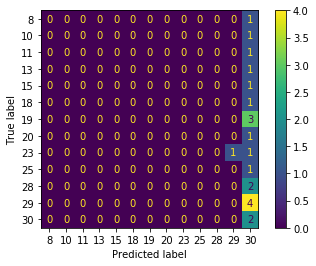

In [74]:
# Create and show confusion matrix
plot_confusion_matrix(lr_model, X_test, y_test, labels=np.unique(y_test))
plt.show()  

In [75]:
# save the model to disk at current working directory
# filename = 'logistic_regression_model.pkl'
# joblib.dump(lr_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(X_train.columns)
# joblib.dump(model_columns, 'logistic_regression_model_columns.pkl')

['logistic_regression_model_columns.pkl']

# SVM multi class classification based on stage

In [76]:
# Should be same data
# 'OVO' gets better results for some reason
# Linear kernel gets better results for some reason
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [77]:
start=time.time()

param_values = {
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                'decision_function_shape' : ['ovo']
           }

# Try out the different n_estimators parameters
svm_model = GridSearchCV(estimator = SVC(), param_grid = param_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

best_svm_C_value = svm_model.best_params_['C']
best_kernel_value = svm_model.best_params_['kernel']

print("Best C: " + str(best_svm_C_value) + ", best kernel: " + str(best_kernel_value))

end=time.time()

print(classification_report(svm_pred, y_test))

Best C: 2, best kernel: sigmoid
              precision    recall  f1-score   support

           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         4
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         1
          30       1.00      0.12      0.21        17

    accuracy                           0.09        22
   macro avg       0.07      0.01      0.02        22
weighted avg       0.77      0.09      0.16     

In [78]:
print("This took: " + str(end-start) + " seconds")

This took: 2.360733985900879 seconds


In [79]:
print("Accuracy: ", accuracy_score(y_test, svm_pred))

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=svm_pred, squared=False))

Accuracy:  0.09090909090909091
RMSE:  9.737462801889505


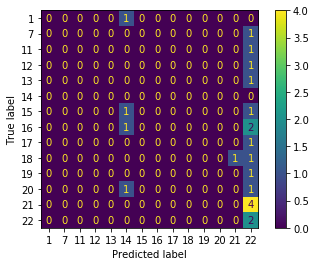

In [80]:
# Create and show confusion matrix
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()  

In [103]:
# save the model to disk at current working directory
# filename = 'svm_model.pkl'
# joblib.dump(svm_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(x.columns)
# joblib.dump(model_columns, 'svm_model_columns.pkl')

['svm_model.pkl']

# Random forest classifier

In [74]:
# creating a RF classifier 
random_forest = RandomForestClassifier()   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
random_forest.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
start=time.time()

n_estimators_values = {'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

# Try out the different n_estimators parameters
rf_model = GridSearchCV(estimator = RandomForestClassifier(), param_grid = n_estimators_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)

best_n_estimators = rf_model.best_params_['n_estimators']
print("best n_estimators: " + str(best_n_estimators))

end=time.time()

print(classification_report(rf_pred, y_test))

best n_estimators: 1000
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         0
          28       0.33      1.00      0.50         1
          29       0.00      0.00      0.00         7
          30       0.29      0.22      0.25         9

    accuracy                           0.14        21
   macro avg       0.05      0.09      0.06        21
weighted avg       0.14      0.14      0.13        21



In [76]:
print("This took: " + str(end-start) + " seconds")

This took: 20.963252305984497 seconds


In [108]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, rf_pred)) 

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=rf_pred, squared=False))

ACCURACY OF THE MODEL:  0.14285714285714285
RMSE:  7.88005317845242


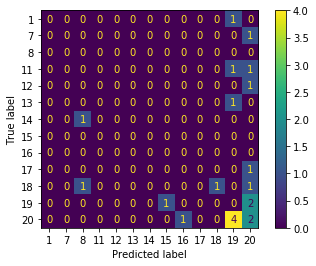

In [78]:
# Create and show confusion matrix
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()  

In [104]:
# save the model to disk at current working directory
# filename = 'rf_model.pkl'
# joblib.dump(rf_model, filename)

# Persist model columns to make model more robust on call
# model_columns = list(x.columns)
# joblib.dump(model_columns, 'rf_model_columns.pkl')

['rf_model.pkl']

# Neural net

In [ ]:
start=time.time()

# Set up N-fold cross validation to find best parameters
parameters = {    
    'hidden_layer_sizes': [
        (1,), (2,), (5,), (10,), (20,), (50,), (100,),
        (1,1), (2,2), (5,5), (10,10), (20,20), (50,50), (100,100),
        (1,1,1), (2,2,2), (5,5,5), (10,10,10), (20,20,20), (50,50,50), (100,100,100)
    ], 
    'activation': ["logistic", "relu", "tanh"],
    'solver': ['lbfgs'], 
    'alpha': 10.0 ** -np.arange(1, 10), 
    'max_iter': [200, 500, 1000], 
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7,1e-8],
    'verbose' : [True] # to print out messages for debugging later
}

# n_jobs -1 maximizes jobs in background
clf = GridSearchCV(MLPClassifier(), parameters, cv = None, scoring = 'accuracy', n_jobs=-1)

# Create train and test the model
clf.fit(X_train, y_train)
# best_score = clf.score(X_test, y_test)
    
# Print the classification report for the NN model
mlp_pred = clf.predict(X_test)

print("Best parameters are: ")
print(clf.best_params_)
print("Classification report starts here: ")
print(classification_report(mlp_pred, y_test))
end=time.time()

In [ ]:
print("This took: " + str(end-start) + " seconds")

In [ ]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, mlp_pred))

# squared = False gets RMSE (squared=True gets MSE)
print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=mlp_pred, squared=False))

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
plt.show()  

In [ ]:
# save the model to disk at current working directory
# filename = 'nn_model.pkl'
# joblib.dump(clf, filename)

# Persist model columns to make model more robust on call
# model_columns = list(x.columns)
# joblib.dump(model_columns, 'nn_model_columns.pkl')